# **Task 2: Fine-tuning LLM for code generation**

### Name: Asmita Sengupta
### Matriculation No.: 427240
### Engineering with Gen AI WiSe '23 - Portfolio submission for Task 2
---


## In this task, a large language model namely, **Llama 2-7B** has been fine-tuned on a dataset for *Python code generation (text2code)*. The details of the model and dataset are given below:


*   Model: https://huggingface.co/NousResearch/Llama-2-7b-chat-hf
*   Dataset: https://huggingface.co/datasets/iamtarun/python_code_instructions_18k_alpaca

## It is further fine-tuned on synthetic data generated using the designed prompt and given API key, and lastly by combining the synthetic data and the initial training data taken from the chosen dataset and again fine-tuning the model. The following notations have been used to refer to the models throughout this task:


*   **Model A:** The chosen base model for this project. (not fine-tuned)

*   **Model B:** The fine-tuned model A on the training data of the chosen dataset.
*   **Model C:** The fine-tuned model A on the generated synthetic data.


*   **Model D:** The fine-tuned model A on the combined data (training data + synthetic data)




## The **codeBLEU metric** has been used to evaluate the performance of all 4 models on the test data, for this task.



---


##This notebook has been divided into 4 sections to distinctly segregate the tasks performed.


#### *   **Section 1:** The chosen model and dataset are loaded. Evaluation is done using the test data on Model A. It is then fine-tuned to get Model B and the performance of this fine-tuned model is again evaluated using the test data and selected evaluation metric.

#### *   **Section 2:** Synthetic data is generated using the API key and designed prompt. This data is used for fine-tuning Model A which results in Model C. Performance of Model C on the chosen test data is then evaluated using the selected evaluation metric.
#### *   **Section 3:** The training data and synthetic data are combined together. This combined data is used to further fine-tune Model A which results in Model D. Performance of Model D on the chosen test data is evaluated using the selected evaluation metric.


#### *   **Section 4:** A visualization is plotted which shows the performance of all four models on the test data.




---







## **Section 1:**  The dependencies for completing this task are installed. The model and dataset are then loaded and an inference is performed on the (base) model A using the test data from the dataset. The codeBLEU score is calculated during inference. The base model A is then fine-tuned using PEFT and we get model B. The codeBLEU metric is again used to evaluate model B's performance on the test data.



###    **Installing dependencies**



In [ ]:
# Install Libraries & import packages

!pip install -q transformers>=4.32.0 datasets evaluate                                                # Comes from HuggingFace
!pip install -q -U bitsandbytes                                                                       # For quantization
!pip install -q -U peft                                                                               # Parameter-efficient Fine-tuning
!pip install -q -U accelerate                                                                         # Loading models across GPUs/CPU/disk
!pip install -q -U trl                                                                                # For supervised fine-tuning for LLMs
!pip install -q transformers[torch]
!pip install -q tokenizers                                                                            # For effective tokenization
!pip install -q git+https://github.com/k4black/codebleu.git                                           # codeBLEU metric framework
import torch                                                                                          # Deep Learning Framework
import time                                                                                           # Measure inference time
import pandas as pd                                                                                   # For table dataset structure
import numpy as np                                                                                    # Numerical operations on the CPU
from datasets import load_dataset                                                                     # Loading the dataset
import random                                                                                         # Will use for shuffling
from codebleu import calc_codebleu                                                                    # Used for evaluation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.0/417.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

### **Loading the base model (Model A)**

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
# 1. Setup the quantization configuarion
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                     # Q = 4 bits
    bnb_4bit_use_double_quant=True,        # double quantization, quantizing the quantization constants for memory savings
    bnb_4bit_quant_type="nf4",             # 4-bit NormalFloat Quantization (optimal for normal weights; enforces w ∈ [-1,1])
    bnb_4bit_compute_dtype=torch.bfloat16  # Dequantize to 16-bits before computations (as in the paper)
)
# 2. Pass it while using the model
model = AutoModelForCausalLM.from_pretrained("NousResearch/Llama-2-7b-hf", quantization_config=bnb_config, device_map="auto")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

### **Loading the tokenizer**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-hf")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

### **Loading the dataset and defining the train, validation and test split**

Dataset: https://huggingface.co/datasets/iamtarun/python_code_instructions_18k_alpaca

The dataset is split into a training, validation and test set with 300, 100, 100 examples respectively.

In [ ]:
train_dataset = load_dataset("iamtarun/python_code_instructions_18k_alpaca", split=f"train[:{300}]")
print(train_dataset)
test_dataset = load_dataset("iamtarun/python_code_instructions_18k_alpaca", split=f"train[{700}:{800}]")
print(test_dataset)
validation_dataset = load_dataset("iamtarun/python_code_instructions_18k_alpaca", split=f"train[{900}:{1000}]")
print(validation_dataset)

Generating train split:   0%|          | 0/18612 [00:00<?, ? examples/s]

Dataset({
    features: ['instruction', 'input', 'output', 'prompt'],
    num_rows: 300
})
Dataset({
    features: ['instruction', 'input', 'output', 'prompt'],
    num_rows: 100
})
Dataset({
    features: ['instruction', 'input', 'output', 'prompt'],
    num_rows: 100
})


The ***remove_colm*** function removes the extra columns that are not required in the train and validation dataset while fine-tuning the model.

In [ ]:
def remove_colm(data):
    return data.remove_columns(['instruction', 'input', 'output'])

In [ ]:
train_data = remove_colm(train_dataset.shuffle(seed=42).select([i for i in range(300)]))
print(train_data)
val_data  = remove_colm(validation_dataset.shuffle(seed=42).select([i for i in range(100)]))
print(val_data)

Dataset({
    features: ['prompt'],
    num_rows: 300
})
Dataset({
    features: ['prompt'],
    num_rows: 100
})


### **Inference taken on model A (before fine-tuning it) using the codeBLEU evaluation metric**

In [ ]:
predicted_outputs = []
ground_truths = []

# Loop through each item in test_data
for i in range(len(test_dataset)):
  prompt = f"""Below is an instruction that describes a task. Write a response that appropriately completes the request.
        ### Instruction:
        {test_dataset[i]['instruction']}

        ### Input:
        {test_dataset[i]['input']}

        ### Output:

        """
    # Tokenize the input
  inputs = tokenizer(prompt, return_tensors='pt')
  output_tokens = model.generate(inputs["input_ids"].to('cuda'), max_new_tokens=100)[0]
  predicted_output = tokenizer.decode(output_tokens, skip_special_tokens=True)[len(prompt):].strip()
  #print("predictions")

  predicted_outputs.append(predicted_output)
  ground_truth = test_dataset[i]['output']
  ground_truths.append(ground_truth)


result_model_a = calc_codebleu(ground_truths, predicted_outputs, lang="python", weights=(0.25, 0.25, 0.25, 0.25), tokenizer=None)
print(result_model_a)

{'codebleu': 0.09923386092547774, 'ngram_match_score': 0.03104303197041828, 'weighted_ngram_match_score': 0.0318950830199714, 'syntax_match_score': 0.08237339708758966, 'dataflow_match_score': 0.25162393162393165}


### **Google drive is mounted to save the models that have been fine-tuned in the next steps.**

It becomes convenient to load them by mentioning their path in the drive for getting inference after fine-tuning.

In [ ]:
#mounting gdrive for saving the models
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Setting up PEFT**

###The fine-tuning approach used for this task is PEFT (Parameter-Efficient Fine-Tuning). The `prepare_model_for_kbit_training` method from PEFT is used for applying some pre-processing to the model to prepare it for training.

In [ ]:
from peft import prepare_model_for_kbit_training, LoraConfig, PeftConfig, get_peft_model

# 1. prepare model for LoRA
model = prepare_model_for_kbit_training(model) #involves float conversions that help stabilize training

# 2. Setup LoRA Config
lora_config = LoraConfig(
    r=16,                                                       # The rank of the LoRA matrices A, B
    lora_alpha=64,                                              # Scales the product AB
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],    # Will apply LoRA to attention matrices
    lora_dropout=0.1,                                           # Dropout to help lessen overfitting
    bias="none",                                                # Don't train the bias parameter
    task_type="CAUSAL_LM"
)

# 3. Get model with unfrozen LoRA layers
model = get_peft_model(model, lora_config)


### The hyperparameters for training the model are passed in `TrainingArguments`

In [ ]:
from transformers import TrainingArguments

training_arguments = TrainingArguments(
    fp16=True,                           # Training computations in 16 bits
    # batch-related
    per_device_train_batch_size=2,       # Batch Size
    gradient_accumulation_steps=4,       # Batch Size (Mathematically)
    # optimizer-related
    optim="paged_adamw_32bit",           # Variant of AdamW designed to be more efficient on 32-bit GPUs
    learning_rate=1e-4,                  # Learning Rate
    warmup_ratio=0.05,                   # After 5% of the data, learning rate has linearly  from 0 to 1e-4
    lr_scheduler_type="cosine",          # Adjust learning rate sinusoidally
    max_grad_norm=0.3,                   # Clip gradients if less than 0.3 (prevent gradient explosion)
    # epochs and saving
    num_train_epochs=2,                  # Number of Epochs
    save_strategy="epoch",               # Save after each epoch
    output_dir="epoch-finetuned",        # Where to save the model
    # validation
    evaluation_strategy="steps",         # For the next argument
    eval_steps=0.2,                      # Evaluate after 20% of training steps
    # logging-related
    logging_steps=1,                     # Number of update steps between two logs
    group_by_length=True,                # Minimize padding by grouping sentences of similar length
    seed=42,                             # For consistent results
)
model.gradient_checkpointing_enable()    # Store less activations and recompute later
model.config.use_cache = False           # Disable using attention output cache. Should be enabled in inference.

### The model, dataset, lora config & hyperparameters are passed to the SFTTrainer

In [ ]:
from trl import SFTTrainer
trainer = SFTTrainer(
    # tokenizer and model
    tokenizer=tokenizer,
    model=model,
    # dataset and text field
    dataset_text_field="prompt",
    train_dataset=train_data,
    eval_dataset=val_data,
    # LoRA
    peft_config=lora_config,
    # Hyperparameters
    max_seq_length=1024,
    args=training_arguments,
)

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:318: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


###**Training the base model A on training data**

###Fine-tuning base model A on train data from the chosen dataset gives us Model B.

In [ ]:
#training the model

trainer.train()

Step,Training Loss,Validation Loss
15,0.757800,0.734946
30,0.646500,0.635659
45,0.474700,0.614654
60,0.563300,0.613443


TrainOutput(global_step=74, training_loss=0.6505180867137136, metrics={'train_runtime': 926.9961, 'train_samples_per_second': 0.647, 'train_steps_per_second': 0.08, 'total_flos': 5137323663015936.0, 'train_loss': 0.6505180867137136, 'epoch': 1.9733333333333334})

### **The fine-tuned model B is now saved in drive**

In [ ]:
#saving the trained model

peft_model_path ="./fine-tuned-llama-model_b"
trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

('./fine-tuned-llama-model_b/tokenizer_config.json',
 './fine-tuned-llama-model_b/special_tokens_map.json',
 './fine-tuned-llama-model_b/tokenizer.model',
 './fine-tuned-llama-model_b/added_tokens.json',
 './fine-tuned-llama-model_b/tokenizer.json')

###**Load saved LLM Model B and tokenizer**

In [ ]:
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer

#drive.mount('/content/drive')
# Define paths
drive_path = "/content/drive/MyDrive/fine-tuned-llama-model_b"
peft_model_path = "./fine-tuned-llama-model_b"
# Copy the directory from Google Drive
shutil.copytree(drive_path, peft_model_path)

tuned_model = AutoPeftModelForCausalLM.from_pretrained(peft_model_path, low_cpu_mem_usage=True, torch_dtype=torch.float16, load_in_4bit=True)
tokenizer = AutoTokenizer.from_pretrained(peft_model_path)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


### **Inference taken on model B using the codeBLEU evaluation metric**

In [ ]:

predicted_outputs = []
ground_truths = []

# Loop through each item in test_data
for i in range(len(test_dataset)):
  prompt = f"""Below is an instruction that describes a task. Write a response that appropriately completes the request.
        ### Instruction:
        {test_dataset[i]['instruction']}

        ### Input:
        {test_dataset[i]['input']}

        ### Output:

        """
    # Tokenize the input
  input_ids = tokenizer(prompt, return_tensors='pt',truncation=True).input_ids.cuda()
  outputs = tuned_model.generate(input_ids=input_ids, max_new_tokens=100, )
  predicted_output= tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(prompt):].strip()
  predicted_outputs.append(predicted_output)
  ground_truth = test_dataset[i]['output']
  ground_truths.append(ground_truth)


result_model_b = calc_codebleu(ground_truths, predicted_outputs, lang="python", weights=(0.25, 0.25, 0.25, 0.25), tokenizer=None)
print(result_model_b)

/usr/local/lib/python3.10/dist-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


{'codebleu': 0.17269246451885323, 'ngram_match_score': 0.07080961189948436, 'weighted_ngram_match_score': 0.08247255769497777, 'syntax_match_score': 0.291675722668985, 'dataflow_match_score': 0.24581196581196582}


## **Section 2:**  A prompt is designed to generate Synthetic data using the given API key. The size of the data is three times that of the training data. The generated data is then cleaned/formatted which is used for fine-tuning base model A. This gives us Model C. The codeBLEU metric is similarly used to evaluate the performance of Model C.





###**Generating synthetic data using API key**

In [ ]:
AWS_API_KEY = "BC51B5A7C0914585836512E7485DF0B1"

In [ ]:
import requests
import json

#The llama_generate() function generates the prompt
def llama_generate(prompt,
                   api_token,
                   max_gen_len = 512,
                   temperature = 0.7,
                   top_p =0.9):
  url = 'https://6xtdhvodk2.execute-api.us-west-2.amazonaws.com/dsa_llm/generate'
  body = {
    "prompt": prompt,
    "max_gen_len": max_gen_len,
    "temperature": temperature,
    "top_p": top_p,
    "api_token": api_token
  }
  res = requests.post(url,  json = body)
  return  json.loads(res.text)["body"]["generation"]

 **Prompt designed for generating synthetic data**

The prompt has been designed in such a way to ensure the LLM outputs only the required data for crafting the synthetic data. Constraints mention what the LLM should not generate. This ensures no unnecessary data is generated by the LLM.
Examples have been given so that the LLM knows what and how should it structure its response.

Incorporating these points have ensured in generating clean responses from the LLM.

In [ ]:
prompt = f"""

Scenario: You are a helpful and honest code assistant. Your language of choice is Python. Your answers must not include harmful or unethical content.

#You must generate diverse python coding questions and their corresponding solution in the form of 'Instruction' and 'Output' pair as described below.

#Instruction: Formulate a python coding question here.
#Output: Generate a solution in python for the asked question here.

#Constraint: Don't explain the code, only generate 5 'Instruction' and 'Output' pairs.


#Instruction: Write a Python program to find the sum of the digits of a given number.
#Output:
```
def sum_digits(n):
    s = 0
    while n > 0:
        s += n % 10
        n //= 10
    return s
print(sum_digits(123))

#Instruction: Write a Python program that can convert degrees Fahrenheit to degrees Celsius..
#Output:
```
def FahrenheitToCelsius(temp_fahrenheit):
    temp_celsius = (temp_fahrenheit - 32) * 5/9 return temp_celsius
print(temp_celsius)

#Instruction: Write a Python program that takes a string as input and returns a list of unique characters sorted in alphabetical order.
#Output:
```
def unique_characters(string):
    unique_characters = sorted(set(string))
print(unique_characters)

"""
#print(llama_generate(prompt, AWS_API_KEY))


The code block below generates synthetic data by using the `llama_generate` function which takes in the prompt and API key to fetch responses from the LLM. The generated data is then stored in the JSON file **"gen_data.json"**.

In [ ]:
# Load existing data if it exists
existing_data = []
file_path = '/content/drive/My Drive/gen_data.json'
try:
    with open(file_path, 'r') as json_file:
        existing_data = json.load(json_file)
except FileNotFoundError:
    pass

# Initialize an empty list to store the output of each function call
data_strings = []

# Perform the task inside a loop
for _ in range(10):
    # Call the function and append its output to the list
    data_strings.append(llama_generate(prompt, AWS_API_KEY))

# Combine existing data with new data
all_data = existing_data + data_strings

# Write the combined data to the JSON file
with open(file_path, 'w') as json_file:
    json.dump(all_data, json_file)

The generated data is cleaned and formatted and saved in the JSON file **"synthetic_data.json"**.
The synthetic dataset has 903 examples.

In [ ]:
from datasets import Dataset
# Load the JSON file
with open("/content/drive/My Drive/gen_data.json", "r") as json_file:
    data = json.load(json_file)

instruction_output_pairs = []

# Iterate over each string in the data
for string in data:
    # Split the string into individual instructions and outputs
    pairs = string.split("\n#Instruction:")[1:]
    for pair in pairs:
      if "#Output:\n```" in pair:
            instruction, output = pair.split("#Output:\n```")[0], pair.split("#Output:\n```")[1]
            instruction_output_pairs.append((instruction.strip(), output.strip()))

# Convert list of tuples to dictionary
data_dict = {"Instruction": [pair[0] for pair in instruction_output_pairs],
             "Output": [pair[1] for pair in instruction_output_pairs],
             "Prompt": ["Below is an instruction that describes a task. Write a response that appropriately completes the request. ### Instruction: {} ### Output: {}".format(pair[0], pair[1]) for pair in instruction_output_pairs]}

# Create a dataset from the dictionary
dataset = Dataset.from_dict(data_dict)

# Print the dataset
print(dataset)

# Convert dataset to pandas DataFrame
df = dataset.to_pandas()

# Remove duplicates
df = df.drop_duplicates()

json_file_path = "/content/drive/My Drive/synthetic_data.json"
df.to_json(json_file_path, orient="records") #JSON file containing the cleaned synthetic data


### **Loading the synthetic dataset**

The dataset is split into training and validation with 803 and 100 examples respectively.

In [ ]:
from datasets import Dataset

# Load JSON file into dataset
synthetic_dataset = Dataset.from_json("/content/drive/My Drive/synthetic_data.json")
synthetic_dataset = synthetic_dataset.remove_columns(['Instruction', 'Output']).shuffle(seed=42)  #These columns are removed from the synthetic dataset as they are not required for training.

# Print the dataset
print(synthetic_dataset)

synthetic_train_data = synthetic_dataset.select(range(803))     #data for training
synthetic_val_data = synthetic_dataset.select(range(803, 903))  #data for validation



Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['Prompt'],
    num_rows: 903
})


###**Fine-tuning initial model (A) on the generated synthetic data to get model C**

Similar to how model B was trained, the PEFT setup is done, hyperparameters are passed to `TrainingArguments` and the model, dataset, loraconfig and trainingarguments are then passed to the SFTTrainer for training.

In [ ]:
from peft import prepare_model_for_kbit_training, LoraConfig, PeftConfig, get_peft_model

# 1. prepare model for LoRA
model = prepare_model_for_kbit_training(model) #involves float conversions that help stabilize training

# 2. Setup LoRA Config
lora_config = LoraConfig(
    r=16,                                                       # The rank of the LoRA matrices A, B
    lora_alpha=64,                                              # Scales the product AB
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],    # Will apply LoRA to attention matrices
    lora_dropout=0.1,                                           # Dropout to help lessen overfitting
    bias="none",                                                # Don't train the bias parameter
    task_type="CAUSAL_LM"
)

# 3. Get model with unfrozen LoRA layers
model = get_peft_model(model, lora_config)

In [ ]:
#setting up the hyperparameters for training
from transformers import TrainingArguments

training_arguments = TrainingArguments(
    fp16=True,                           # Training computations in 16 bits
    # batch-related
    per_device_train_batch_size=2,       # Batch Size
    gradient_accumulation_steps=4,       # Batch Size (Mathematically)
    # optimizer-related
    optim="paged_adamw_32bit",           # Variant of AdamW designed to be more efficient on 32-bit GPUs
    learning_rate=1e-4,                  # Learning Rate
    warmup_ratio=0.05,                   # After 5% of the data, learning rate has linearly  from 0 to 1e-4
    lr_scheduler_type="cosine",          # Adjust learning rate sinusoidally
    max_grad_norm=0.3,                   # Clip gradients if less than 0.3 (prevent gradient explosion)
    # epochs and saving
    num_train_epochs=2,                  # Number of Epochs
    save_strategy="epoch",               # Save after each epoch
    output_dir="epoch-finetuned",        # Where to save the model
    # validation
    evaluation_strategy="steps",         # For the next argument
    eval_steps=0.2,                      # Evaluate after 20% of training steps
    # logging-related
    logging_steps=1,                     # Number of update steps between two logs
    group_by_length=True,                # Minimize padding by grouping sentences of similar length
    seed=42,                             # For consistent results
)
model.gradient_checkpointing_enable()    # Store less activations and recompute later
model.config.use_cache = False           # Disable using attention output cache. Should be enabled in inference.

In [ ]:
#passing model, dataset, lora config & hyperparameters to Supervised Fine-tuning trainer

from trl import SFTTrainer
trainer = SFTTrainer(
    # tokenizer and model
    tokenizer=tokenizer,
    model=model,
    # dataset and text field
    dataset_text_field="Prompt",
    train_dataset=synthetic_train_data,
    eval_dataset=synthetic_val_data,
    # LoRA
    peft_config=lora_config,
    # Hyperparameters
    max_seq_length=1024,
    args=training_arguments,
)

Map:   0%|          | 0/803 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:318: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


###**Training the base model A on synthetic data**

###Fine-tuning base model A on the synthetic dataset gives us Model C.

In [ ]:
#training the model

trainer.train()

Step,Training Loss,Validation Loss
40,0.264600,0.197957
80,0.158900,0.164296
120,0.186300,0.146499
160,0.142900,0.136876
200,0.155500,0.134805


TrainOutput(global_step=200, training_loss=0.2684385222569108, metrics={'train_runtime': 1594.2346, 'train_samples_per_second': 1.007, 'train_steps_per_second': 0.125, 'total_flos': 7334610784198656.0, 'train_loss': 0.2684385222569108, 'epoch': 1.9900497512437811})

### **The fine-tuned model C is now saved in drive**

In [ ]:
#saving the trained model C

peft_model_path ="./fine-tuned-llama-model_c"
trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

('./fine-tuned-llama-model_c/tokenizer_config.json',
 './fine-tuned-llama-model_c/special_tokens_map.json',
 './fine-tuned-llama-model_c/tokenizer.model',
 './fine-tuned-llama-model_c/added_tokens.json',
 './fine-tuned-llama-model_c/tokenizer.json')

###**Load saved LLM Model C and tokenizer**

In [ ]:
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer

#drive.mount('/content/drive')
# Define paths
drive_path = "/content/drive/MyDrive/fine-tuned-llama-model_c"
peft_model_path = "./fine-tuned-llama-model_c"
# Copy the directory from Google Drive
shutil.copytree(drive_path, peft_model_path)

tuned_model_c = AutoPeftModelForCausalLM.from_pretrained(peft_model_path, low_cpu_mem_usage=True, torch_dtype=torch.float16, load_in_4bit=True)
tokenizer = AutoTokenizer.from_pretrained(peft_model_path)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


### **Inference taken on model C using the codeBLEU evaluation metric**

In [ ]:
predicted_outputs = []
ground_truths = []

# Loop through each item in test_data
for i in range(len(test_dataset)):
  prompt = f"""Below is an instruction that describes a task. Write a response that appropriately completes the request.
        ### Instruction:
        {test_dataset[i]['instruction']}

        ### Input:
        {test_dataset[i]['input']}

        ### Output:

        """
    # Tokenize the input
  input_ids = tokenizer(prompt, return_tensors='pt',truncation=True).input_ids.cuda()
  outputs = tuned_model_c.generate(input_ids=input_ids, max_new_tokens=100, )
  predicted_output= tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(prompt):].strip()
  predicted_outputs.append(predicted_output)
  ground_truth = test_dataset[i]['output']
  ground_truths.append(ground_truth)


result_model_c = calc_codebleu(ground_truths, predicted_outputs, lang="python", weights=(0.25, 0.25, 0.25, 0.25), tokenizer=None)
print(result_model_c)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


{'codebleu': 0.15421377883511803, 'ngram_match_score': 0.05164903674203302, 'weighted_ngram_match_score': 0.06817849076450484, 'syntax_match_score': 0.25429254509889154, 'dataflow_match_score': 0.24273504273504273}


## **Section 3:**  The training data and synthetic data are now combined. This combined data is then used for fine-tuning base model A. This gives us Model D. The codeBLEU metric is similarly used to evaluate the performance of Model D.

Before combining the train and synthetic dataset, the column names have been formatted such that both datasets have a uniformity.

In [ ]:
train_dataset = train_dataset.rename_column("instruction", "Instruction")
train_dataset = train_dataset.rename_column("output", "Output")
train_dataset = train_dataset.rename_column("prompt", "Prompt")

In [ ]:
print(synthetic_dataset)

Dataset({
    features: ['Prompt'],
    num_rows: 903
})


###**Combining the training and synthetic dataset**

In [ ]:
from datasets import Dataset, concatenate_datasets


# Concatenate the datasets vertically
combined_dataset = concatenate_datasets([train_dataset, synthetic_dataset]).shuffle(seed=42)
combined_dataset = combined_dataset.remove_columns(['Instruction', 'input' , 'Output'])
# Print the combined dataset
print(combined_dataset)


combined_train_data = combined_dataset.select(range(1103)).shuffle(seed=42)       #part of dataset used for training
combined_val_data = combined_dataset.select(range(1103, 1203)).shuffle(seed=42)   #part of dataset used for validation

# Print the number of samples in each split
print(combined_train_data)
print(combined_val_data)

Dataset({
    features: ['Prompt'],
    num_rows: 1203
})
Dataset({
    features: ['Prompt'],
    num_rows: 1103
})
Dataset({
    features: ['Prompt'],
    num_rows: 100
})


###**Fine-tuning initial model (A) on the combined data to get model D**

Similar to how model B and C were trained, the PEFT setup is done, hyperparameters are passed to `TrainingArguments` and the model, dataset, loraconfig and trainingarguments are then passed to the SFTTrainer for training.

In [ ]:
from peft import prepare_model_for_kbit_training, LoraConfig, PeftConfig, get_peft_model

# 1. prepare model for LoRA
model = prepare_model_for_kbit_training(model) #involves float conversions that help stabilize training

# 2. Setup LoRA Config
lora_config = LoraConfig(
    r=16,                                                       # The rank of the LoRA matrices A, B
    lora_alpha=64,                                              # Scales the product AB
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],    # Will apply LoRA to attention matrices
    lora_dropout=0.1,                                           # Dropout to help lessen overfitting
    bias="none",                                                # Don't train the bias parameter
    task_type="CAUSAL_LM"
)

# 3. Get model with unfrozen LoRA layers
model = get_peft_model(model, lora_config)

In [ ]:
from transformers import TrainingArguments

training_arguments = TrainingArguments(
    fp16=True,                           # Training computations in 16 bits
    # batch-related
    per_device_train_batch_size=1,       # Batch Size
    gradient_accumulation_steps=4,       # Batch Size (Mathematically)
    # optimizer-related
    optim="paged_adamw_32bit",           # Variant of AdamW designed to be more efficient on 32-bit GPUs
    learning_rate=1e-4,                  # Learning Rate
    warmup_ratio=0.05,                   # After 5% of the data, learning rate has linearly  from 0 to 1e-4
    lr_scheduler_type="cosine",          # Adjust learning rate sinusoidally
    max_grad_norm=0.3,                   # Clip gradients if less than 0.3 (prevent gradient explosion)
    # epochs and saving
    num_train_epochs=2,                  # Number of Epochs
    save_strategy="epoch",               # Save after each epoch
    output_dir="epoch-finetuned",        # Where to save the model
    # validation
    evaluation_strategy="steps",         # For the next argument
    eval_steps=0.2,                      # Evaluate after 20% of training steps
    # logging-related
    logging_steps=1,                     # Number of update steps between two logs
    group_by_length=True,                # Minimize padding by grouping sentences of similar length
    seed=42,                             # For consistent results
)
model.gradient_checkpointing_enable()    # Store less activations and recompute later
model.config.use_cache = False           # Disable using attention output cache. Should be enabled in inference.

In [ ]:
from trl import SFTTrainer
trainer = SFTTrainer(
    # tokenizer and model
    tokenizer=tokenizer,
    model=model,
    # dataset and text field
    dataset_text_field="Prompt",
    train_dataset=combined_train_data,
    eval_dataset=combined_val_data,
    # LoRA
    peft_config=lora_config,
    # Hyperparameters
    max_seq_length=1024,
    args=training_arguments,
)

Map:   0%|          | 0/1103 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:318: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


###**Training the base model A on combined data**

###Fine-tuning base model A on the combined dataset (1203 examples) gives us Model D.

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
110,0.319900,0.346927
220,0.148000,0.298562
330,0.482800,0.301281
440,0.178500,0.284084
550,0.168000,0.282095


TrainOutput(global_step=550, training_loss=0.30501183955506844, metrics={'train_runtime': 3633.7946, 'train_samples_per_second': 0.607, 'train_steps_per_second': 0.151, 'total_flos': 1.2031801362653184e+16, 'train_loss': 0.30501183955506844, 'epoch': 1.9945602901178603})

### **The fine-tuned model D is now saved in drive**

In [ ]:
peft_model_path ="./fine-tuned-llama-model_d"
trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

('./fine-tuned-llama-model_d/tokenizer_config.json',
 './fine-tuned-llama-model_d/special_tokens_map.json',
 './fine-tuned-llama-model_d/tokenizer.model',
 './fine-tuned-llama-model_d/added_tokens.json',
 './fine-tuned-llama-model_d/tokenizer.json')

###**Load saved LLM Model D and tokenizer**

In [ ]:
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer


# Define paths
drive_path = "/content/drive/MyDrive/fine-tuned-llama-model_d"
peft_model_path = "./fine-tuned-llama-model_d"
# Copy the directory from Google Drive
shutil.copytree(drive_path, peft_model_path)

tuned_model_d = AutoPeftModelForCausalLM.from_pretrained(peft_model_path, low_cpu_mem_usage=True, torch_dtype=torch.float16, load_in_4bit=True)
tokenizer = AutoTokenizer.from_pretrained(peft_model_path)

### **Inference taken on model D using the codeBLEU evaluation metric**

In [ ]:
predicted_outputs = []
ground_truths = []

# Loop through each item in test_data
for i in range(len(test_dataset)):
  prompt = f"""Below is an instruction that describes a task. Write a response that appropriately completes the request.
        ### Instruction:
        {test_dataset[i]['instruction']}

        ### Input:
        {test_dataset[i]['input']}

        ### Output:

        """
    # Tokenize the input
  input_ids = tokenizer(prompt, return_tensors='pt',truncation=True).input_ids.cuda()
  outputs = tuned_model_d.generate(input_ids=input_ids, max_new_tokens=100, )
  predicted_output= tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0][len(prompt):].strip()
  predicted_outputs.append(predicted_output)
  ground_truth = test_dataset[i]['output']
  ground_truths.append(ground_truth)


result_model_d = calc_codebleu(ground_truths, predicted_outputs, lang="python", weights=(0.25, 0.25, 0.25, 0.25), tokenizer=None)
print(result_model_d)

/usr/local/lib/python3.10/dist-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


{'codebleu': 0.19149307558308992, 'ngram_match_score': 0.08495879570095861, 'weighted_ngram_match_score': 0.10022835587450503, 'syntax_match_score': 0.31993044990219516, 'dataflow_match_score': 0.26085470085470086}


## **Section 4:**  All four models have been evaluated on the selected test data using the codeBLEU evaluation metric. This section shows a visualization of all the model performances using a grouped bar chart.

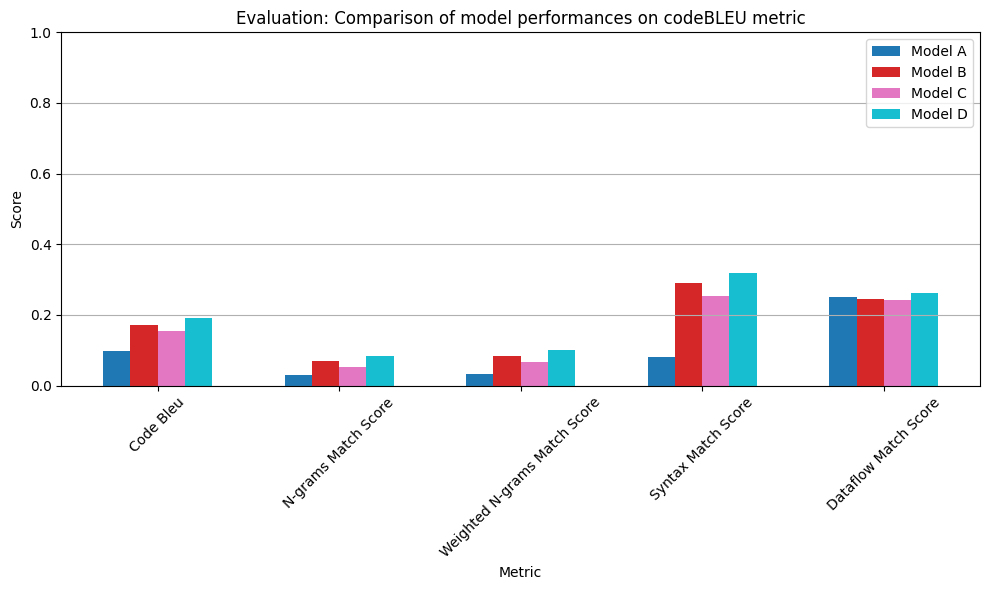

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data
models = ['Model A', 'Model B', 'Model C', 'Model D']
scores = ['Code Bleu', 'N-grams Match Score', 'Weighted N-grams Match Score', 'Syntax Match Score', 'Dataflow Match Score']
data = {
    'Model A': [0.09923386092547774, 0.03104303197041828, 0.0318950830199714, 0.08237339708758966, 0.25162393162393165],
    'Model B': [0.17269246451885323, 0.07080961189948436, 0.08247255769497777, 0.291675722668985, 0.24581196581196582],
    'Model C': [0.15421377883511803, 0.05164903674203302, 0.06817849076450484, 0.25429254509889154, 0.24273504273504273],
    'Model D': [0.19149307558308992, 0.08495879570095861, 0.10022835587450503, 0.31993044990219516, 0.26085470085470086]
}
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.15
index = np.arange(len(scores))

colors = plt.cm.tab10(np.linspace(0, 1, len(models)))

for i, model in enumerate(models):
    ax.bar(index + i * bar_width, data[model], bar_width, color=colors[i], label=model)

ax.set_xlabel('Metric')
ax.set_ylabel('Score')
ax.set_title('Evaluation: Comparison of model performances on codeBLEU metric')
ax.set_xticks(index + bar_width * 1.5)
ax.set_xticklabels(scores, rotation=45)
ax.set_ylim(0, 1)
ax.grid(axis='y')
ax.legend()

plt.tight_layout()
plt.show()

----------------------------------------------------------------------END OF TASK---------------------------------------------------------------------------------------------